In this notebook, I show the data science workflow I used to model new weekly cases of COVID-19 amongst the state prison population in California and Washington using an ARIMAX modeling framework. Under this framework, I attempted to model the *Residents* time series (incarcerated people in the state prison system) using two potential explanatory variables: The time series of *Staff* cases, and the time series of *Statewide* cases. 

In this notebook, I walk through how I performed exploratory data analysis of the three time series variables, flagged and cleaned any flawed data, transformed the data, and modeled the *Residents* time series using one or more of the explantory variables. I show *Out-Of-Time* cross validation predictions to compare the predictive accuracy (MAPE) of models against one another, to aid in model selection for the best model, and show a few figures of the fitting process and predictive modeling steps.

From this project, I found that the *Staff* variable could best explain the *Residents* time series, better than a baseline model using just *Residents* by itself, and better than the *State* time series.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import clean_data
import wrangle_data
import statistics
import numpy as np
import math
import models
import visualize_results
import seaborn as sns
import warnings

main_palette = sns.color_palette("cividis", 6)

font = {'family': 'normal',
        'size': 14}

matplotlib.rc('font', **font)

In [4]:
warnings.filterwarnings("ignore")

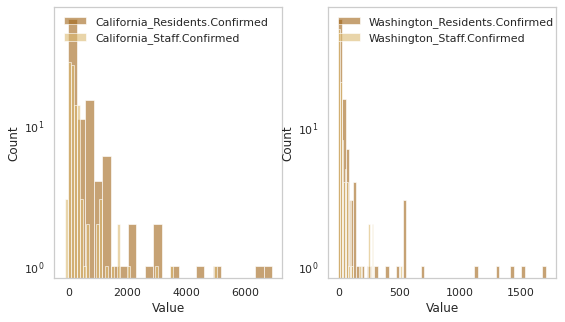

In [5]:
"""
Pre-clean EDA:
Plots of the first difference of the COVID data (to show new weekly cases)
Three time series variables will be used:
Residents, which represents the new weekly cases of people incarcerated in the state prison system specified,
Staff, which represents the new weekly cases of staff who work in the state prison system specified, and
State, which represents the new daily cases reported by the New York Times for the state specified.
"""
data = wrangle_data.load_raw_data("04-06-22")
wrangle_data.eda_plots_for_paper(data)

Series([], Name: Residents.Confirmed, dtype: float64)
Series([], Name: Residents.Confirmed, dtype: float64)
{482: 49230.0, 484: 49224.0}
[]
[53 63 65 86]
[54 66]
[67]
[68]
[69]
[]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


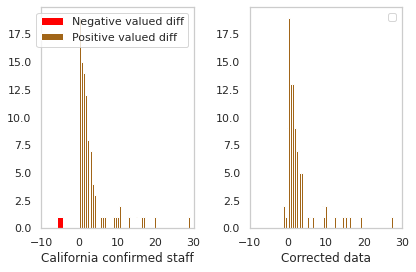

In [6]:
"""
Loading and automating cleaning the data:
Some negative values were found in the first difference of the time series, which is a problem for a cumulative variable.
They were corrected in order to smooth the time series.
"""

data = wrangle_data.load_raw_data("04-06-22")
cleaned_prison_df = clean_data.cleaning_process(data["cases"])
# If file not saved with merged dataset, run the following
# clean_data.merge_data(cleaned_prison_df, data["anchored"], wrangle_data.load_nyt_data())


In [7]:
"""
Loading transformed data:
After the data was cleaned, the Covid prisons data from UCLA was merged with state-level data from the New York Times and saved in the file referenced below.
"""
merged_df = pd.read_csv("./transformed_data/df_transformed_nyt.csv") # Includes NYT state data
merged_df = merged_df.set_index(merged_df["Date"])

Observations of Dickey-fuller test for CA Residents
Test Statistic                     -4.18886
p-value                            0.000688
#lags used                              3.0
number of observations used           102.0
Data                           CA Residents
critical value (1%)               -3.496149
critical value (5%)               -2.890321
critical value (10%)              -2.582122
dtype: object
Observations of Dickey-fuller test for CA Staff
Test Statistic                -4.370493
p-value                        0.000335
#lags used                          3.0
number of observations used       102.0
Data                           CA Staff
critical value (1%)           -3.496149
critical value (5%)           -2.890321
critical value (10%)          -2.582122
dtype: object
Observations of Dickey-fuller test for WA Residents
Test Statistic                    -4.398109
p-value                            0.000299
#lags used                              1.0
number of observ

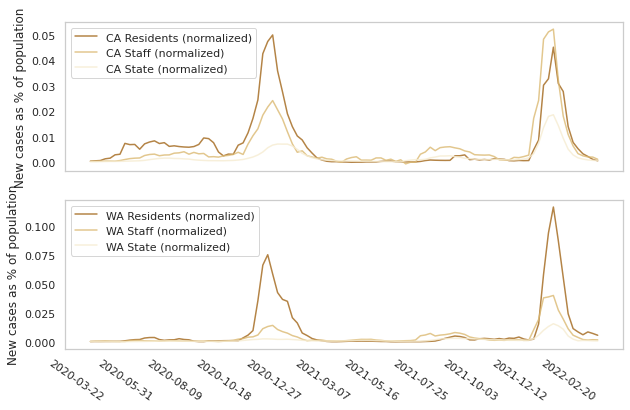

In [8]:
"""
Exploring cleaned merged data:
First, stationarity of the time series is assessed, using the augmented Dickey-Fuller test.
Then the smoothed and transformed data is shown, normalized by population.
"""
statistics.evaluate_stationarity(merged_df)
wrangle_data.eda_post_cleaning(merged_df)

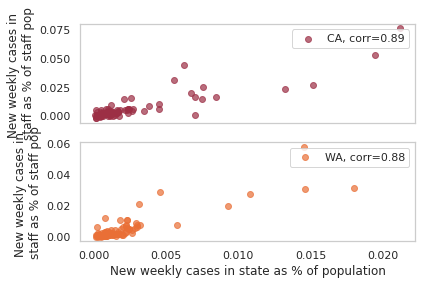

In [9]:
"""
Separating CA and WA data into two dataframes for simplicity:
"""
ca_df = wrangle_data.get_california(merged_df)
wa_df = wrangle_data.get_washington(merged_df)

"""
This plot shows the correlation between new state cases and new staff cases.
You can see that the high correlation could mean that staff cases just represent
a subset of state cases, or that they just reflect the same dynamics.
This also means that both Staff and State should not both be used as exogenous variables in a model to
explain Residents, as they are almost colinear.
"""
wrangle_data.plot_staff_state_corr(ca_df, wa_df)
plt.show()

   lag  correlation
0  0.0     0.768183
1 -1.0     0.562351
2 -2.0     0.393443
3 -3.0     0.236125
Test Statistic                -1.598077
p-value                        0.484559
#lags used                          5.0
number of observations used        75.0
Data                           Raw data
critical value (1%)           -3.520713
critical value (5%)           -2.900925
critical value (10%)          -2.587781
dtype: object
Test Statistic                      -7.157941
p-value                                   0.0
#lags used                                4.0
number of observations used              75.0
Data                           1st difference
critical value (1%)                 -3.520713
critical value (5%)                 -2.900925
critical value (10%)                -2.587781
dtype: object
Test Statistic                      -5.336695
p-value                              0.000005
#lags used                                9.0
number of observations used              69.0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


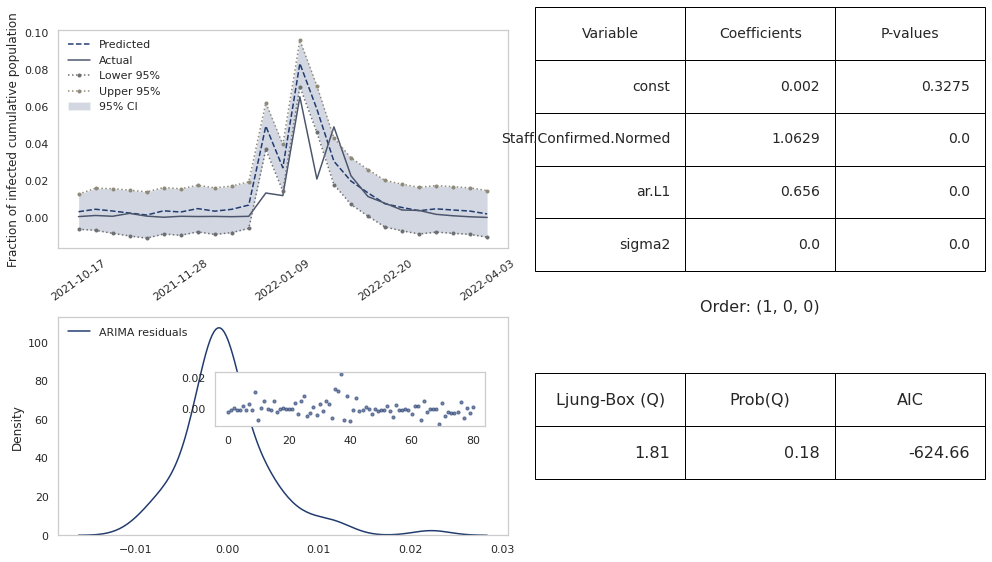

In [10]:
"""
Modeling:
First, the California time series is modeled using an ARIMAX framework. A linear regression of the residents cases is fit
to the staff case time series, and then time series structure of the residuals is modeled. 
The pre-fit analysis shows ACF and PACF plots and stationarity checks, to help manually
parametrize the model. Since the data is already differenced once, and weakly stationary,
an ARIMAX(1,0,0) model is fit and the prediction results are shown in the bottom figure, along with fit diagnostics.

For the prediction, the prediction is made on out-of-sample time series data, in this case, the last 25% of the time series
data that was separated out before fitting.
"""

#### Investigative fits for potential manual fit

ca_model_fitter = models.ModelFitter(ca_df["Residents.Confirmed.Normed"].diff(1).dropna(), x_data=ca_df[["Staff.Confirmed.Normed"]].diff(1).dropna())

ca_model_fitter.split_train_test()
ca_model_fitter.pre_fit_analyze()
ca_model_fitter.fit_model(1,0,0)
sns.set_palette("cividis")
ca_model_fitter.get_results(show=True)

plt.show()

Univar

\begin{tabular}{llrrr}
\toprule
{} &      order &     AIC &    MAPE &  Ljung-Box \\
\midrule
15 &  (2, 1, 0) & -578.17 &  1.2300 &       1.00 \\
9  &  (1, 1, 0) & -577.86 &  1.2456 &       1.00 \\
4  &  (0, 1, 1) & -576.37 &  1.2945 &       0.99 \\
3  &  (0, 1, 0) & -574.57 &  1.4155 &       0.90 \\
5  &  (0, 1, 2) & -579.80 &  1.5851 &       1.00 \\
\bottomrule
\end{tabular}

ARIMAX_staff

\begin{tabular}{llrrr}
\toprule
{} &      order &     AIC &    MAPE &  Ljung-Box \\
\midrule
4 &  (0, 1, 1) & -614.13 &  1.2232 &       0.99 \\
3 &  (0, 1, 0) & -607.72 &  1.2977 &       0.79 \\
9 &  (1, 1, 0) & -615.52 &  1.3427 &       0.98 \\
\bottomrule
\end{tabular}

ARIMAX_state

\begin{tabular}{llrrr}
\toprule
{} &      order &     AIC &    MAPE &  Ljung-Box \\
\midrule
3 &  (0, 1, 0) & -573.56 &  1.0600 &       0.73 \\
4 &  (0, 1, 1) & -579.45 &  1.1352 &       0.94 \\
\bottomrule
\end{tabular}

ARIMAX_both

\begin{tabular}{lrrrr}
\toprule
Empty DataFrame
Columns: Index(['order', 'AI

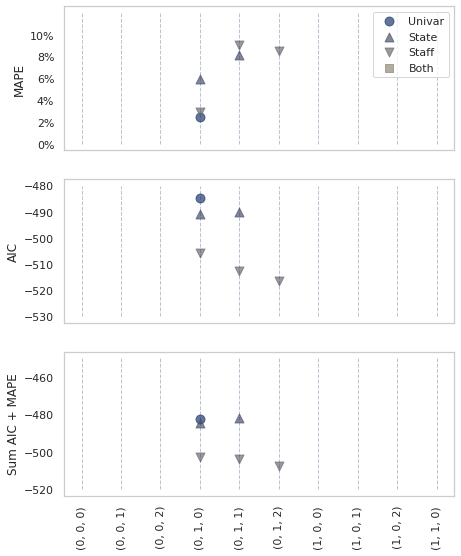

In [11]:
"""
Visualizing and summarizing results:
Outside of this notebook, a grid search was performed to help assess and find the best time series models.
The results are shown below, with MAPE and AIC as a function of parameter combinations for the ARIMA models using
Staff, State, or no exogenous variables to explain the Residents new weekly cases.
"""
sns.set_palette("cividis")
tables = visualize_results.plot_gridsearch_results()

{'predictions': <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x7fb7d709b580>, 'accuracy': {'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan, 'corr': 0.8855397232685243}, 'aic': -514.6453183015408}


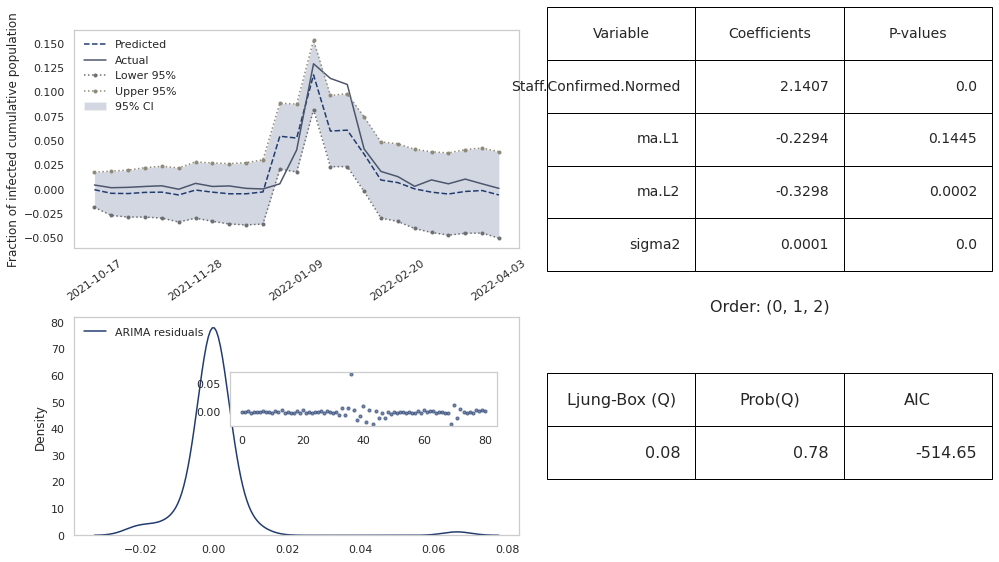

In [12]:
"""
Visualizing one of the best fit models for Washington.
The prediction on out-of-sample time series data was close to the actual, and within the reported confidence intervals.
"""
# Washington, ARIMAX(0,1,2) (Staff)
wa_model_fitter = models.ModelFitter(wa_df["Residents.Confirmed.Normed"].diff(1).dropna(), x_data=wa_df[["Staff.Confirmed.Normed"]].diff(1).dropna())
wa_model_fitter.split_train_test()
wa_model_fitter.fit_model(0,1,2)
sns.set_palette("cividis")
staff2 = wa_model_fitter.get_results(show=True)


{'predictions': <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x7fb7d4a5f610>, 'accuracy': {'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan, 'corr': nan}, 'aic': -484.8140239940299}


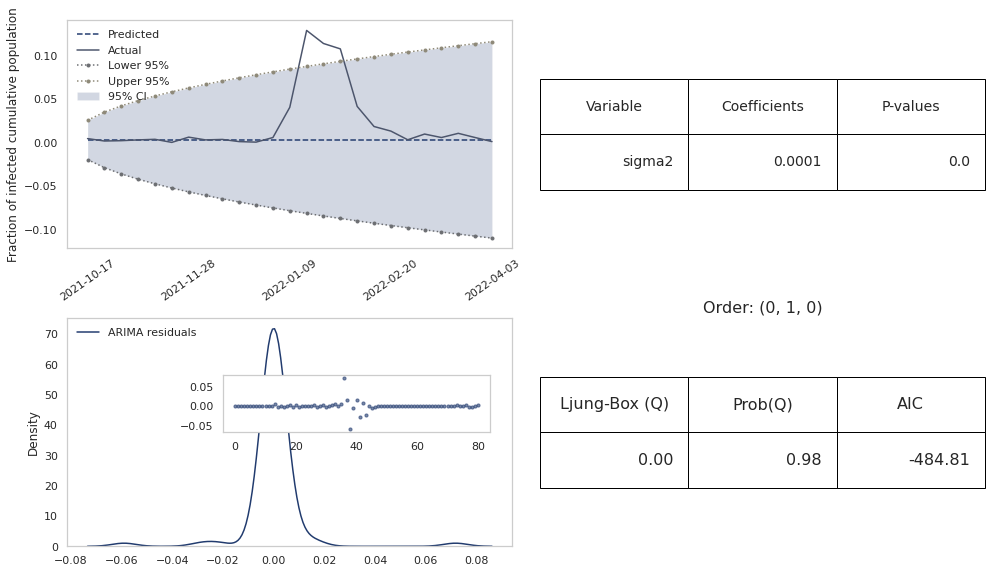

In [13]:
"""
Both of the above models use Staff as the exogenous variable for the Residents time series. To compare against a baseline model,
it is now explored whether or not the Residents time series can model itself as an ARIMA model.
Through analysis not including directly in this notebook (but can be found in project_main.py) it was found
that even the best-scoring model for an ARIMA model that used no exogenous variables did a poor job of
performing on out-of-time cross validation data and was unable to successfully predict a new wave.
"""
# Washington, ARIMA(0,1,0) # lowest MAPE
wa_model_fitter = models.ModelFitter(wa_df["Residents.Confirmed.Normed"].diff(1).dropna())
wa_model_fitter.split_train_test()
wa_model_fitter.fit_model(0,1,0)
self1 = wa_model_fitter.get_results(show=True)